#  Sentinel - Fact-Checking Facebook Politics Pages — Analysis

In [5]:
# time
import time
from datetime import datetime, timedelta
# load and save data 
import pickle
import os
from os.path import expanduser
# manipulate data
import pandas as pd
import numpy as np
# plot data
%matplotlib inline
import matplotlib.pyplot as plt
# sklearn
from sklearn.cross_validation import train_test_split
#from sklearn.model_selection import cross_val_score

from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.grid_search import GridSearchCV

In [6]:
posts = pd.read_csv("../data/facebook-fact-check.csv")

# Data Exploration

In [7]:
posts.head(2)

,account_id,post_id,Category,Page,Post URL,Date Published,Post Type,Rating,Debate,share_count,reaction_count,comment_count
0,184096565021911,1035057923259100,mainstream,ABC News Politics,https://www.facebook.com/ABCNewsPolitics/posts...,2016-09-19,video,no factual content,NaN,NaN,146.0,15.0
1,184096565021911,1035269309904628,mainstream,ABC News Politics,https://www.facebook.com/ABCNewsPolitics/posts...,2016-09-19,link,mostly true,NaN,1.0,33.0,34.0


In [8]:
posts.shape

(2282, 12)

In [9]:
posts.columns

Index([u'account_id', u'post_id', u'Category', u'Page', u'Post URL',
       u'Date Published', u'Post Type', u'Rating', u'Debate', u'share_count',
       u'reaction_count', u'comment_count'],
      dtype='object')

In [10]:
# Label balancing
posts_count = posts.groupby(by=[u'Rating'], as_index=True)\
.agg({u'Rating' : 'count'})\
.rename(columns={u'Rating' : 'N'})\
.sort_values("N",ascending = False)
posts_count

,N
Rating,
mostly true,1669
no factual content,264
mixture of true and false,245
mostly false,104


In [11]:
np.sum(np.sum(posts.isnull()))

2058

In [12]:
np.sum(np.sum(posts.loc[:,u'Debate'].isnull()))

1984

In [13]:
np.sum(np.sum(posts.loc[:,u'share_count'].isnull()))

70

In [14]:
np.sum(np.sum(posts.loc[:,u'reaction_count'].isnull()))

2

In [15]:
np.sum(np.sum(posts.loc[:,u'comment_count'].isnull()))

2

In [16]:
posts.dropna().shape

(292, 12)

In [17]:
posts.describe()

,account_id,post_id,share_count,reaction_count,comment_count
count,2.282000e+03,2.282000e+03,2.212000e+03,2280.000000,2280.000000
mean,1.867111e+14,3.299586e+15,4.044816e+03,5364.284649,516.102193
std,1.393826e+14,3.808724e+15,2.983192e+04,19126.544561,3569.355445
min,6.231759e+10,5.510967e+14,1.000000e+00,2.000000,0.000000
25%,1.145179e+14,1.247441e+15,2.400000e+01,149.000000,37.000000
50%,1.840966e+14,1.290536e+15,9.600000e+01,545.500000,131.500000
75%,3.469371e+14,1.540752e+15,7.390000e+02,2416.750000,390.250000
max,4.401065e+14,1.015386e+16,1.088995e+06,456458.000000,159047.000000


...done in 0.2 s....


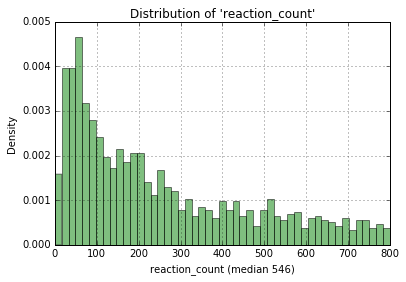

In [18]:
median = np.median(posts.loc[:,u'reaction_count'].dropna())
startTime = time.time()
fig=plt.figure()
plt.title(u"Distribution of 'reaction_count'")
plt.ylabel(u'Density')
plt.xlabel("reaction_count (median {:0.0f})".format(median))
bins = np.linspace(0, 800, 50)
plt.hist(posts[u'reaction_count'], bins, normed=True, facecolor='g', alpha=0.5)
plt.grid()
print("...done in %0.1f s...." % (time.time() - startTime)) 

...done in 0.2 s....


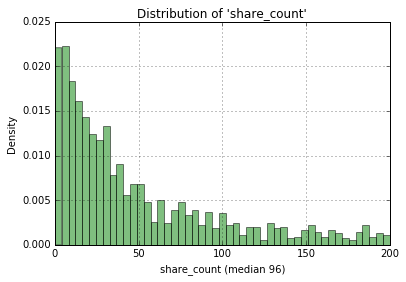

In [19]:
median = np.median(posts.loc[:,u'share_count'].dropna())
startTime = time.time()
fig=plt.figure()
plt.title(u"Distribution of 'share_count'")
plt.ylabel(u'Density')
plt.xlabel("share_count (median {:0.0f})".format(median))
bins = np.linspace(0, 200, 50)
plt.hist(posts[u'share_count'], bins, normed=True, facecolor='g', alpha=0.5)
plt.grid()
print("...done in %0.1f s...." % (time.time() - startTime)) 

...done in 0.2 s....


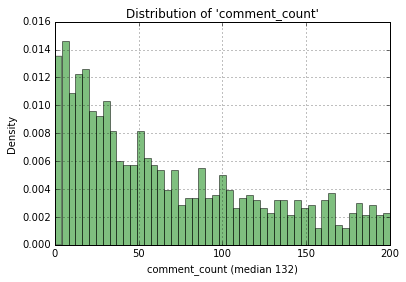

In [20]:
median = np.median(posts.loc[:,u'comment_count'].dropna())
startTime = time.time()
fig=plt.figure()
plt.title(u"Distribution of 'comment_count'")
plt.ylabel(u'Density')
plt.xlabel("comment_count (median {:0.0f})".format(median))
bins = np.linspace(0, 200, 50)
plt.hist(posts[u'comment_count'], bins, normed=True, facecolor='g', alpha=0.5)
plt.grid()
print("...done in %0.1f s...." % (time.time() - startTime)) 

# Preparing data 

In [21]:
# Supression of row with "no factual content"
data = posts.loc[posts[u'Rating']<>"no factual content",:]
# Buildind new label with 2 categories 0 & 1 (1 meaning potential fake...)
data["label"] = 1
data.loc[data[u'Rating']=='mostly true','label'] = 0
# dropping other columns
data = data.loc[:,[u'share_count',u'reaction_count', u'comment_count', u'label']]
print("Number of remaining occurences with at least 1 Nan :%i " % np.sum(np.sum(data.isnull())))
# Supression of row having at least one null value
data = data.dropna()
print("Shape of non null data"),
print data.shape
# Label balancing
balancing = data.groupby(by=[u'label'], as_index=True)\
.agg({u'label' : 'count'})\
.rename(columns={u'label' : 'N'})\
.sort_values("N",ascending = False)
balancing

Number of remaining occurences with at least 1 Nan :45 
Shape of non null data (1977, 4)


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
//anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:461: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,N
label,
0,1633
1,344


rebalancing of categories is needed...

In [45]:
X = data.loc[:,[u'share_count', u'reaction_count', u'comment_count']]
y = data.loc[:,[u'label']]

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [47]:
# data normalisation
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
print "Number exemple: \n- training set: {}\n- test set: {}".format(y_train.shape[0],y_test.shape[0])
print "Number of features: p={}".format(X_train.shape[1])

Number exemple: 
- training set: 1324
- test set: 653
Number of features: p=3


In [48]:
balancing = y_train.groupby(by=[u'label'], as_index=True)\
.agg({u'label' : 'count'})\
.rename(columns={u'label' : 'N'})\
.sort_values("N",ascending = False)
balancing

,N
label,
0,1095
1,229


In [49]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(class_weight='balanced')
clf.fit(X_train,y_train)
r = clf.predict(X_test)

//anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [50]:
clf.score(X_test,y_test)

0.74119448698315471

In [51]:
from sklearn.metrics import confusion_matrix

In [52]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Confusion matrix, without normalization
[[444  94]
 [ 75  40]]
Normalized confusion matrix
[[ 0.83  0.17]
 [ 0.65  0.35]]


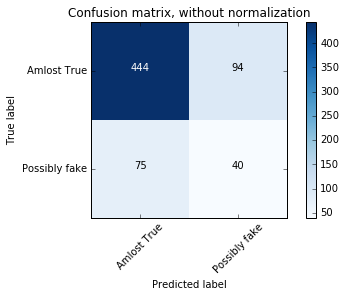

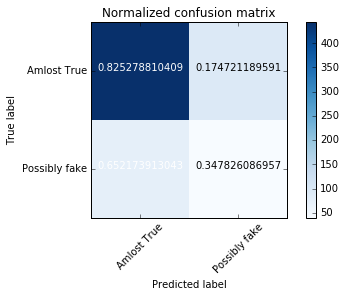

In [53]:
# Compute confusion matrix
y_pred = clf.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
class_names = ['Amlost True','Possibly fake']
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

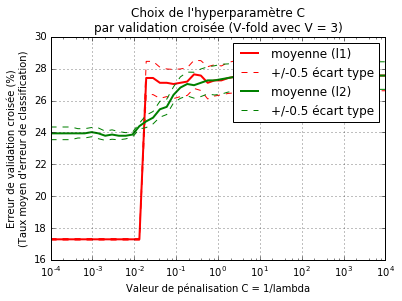

Détermination des paramètres optimaux en 4.3 s
Pénalisation l1, valeur optimale : C = 0.0001
Pénalisation l2, valeur optimale : C = 0.0063


In [69]:
nb_value = 50 # Nombre de valeurs testées pour l'hyperparamètre
mean_score_l1 = np.zeros(nb_value)
mean_score_l2 = np.zeros(nb_value)
C_log = np.logspace(-4,4,nb_value)
cv = 3 # V-fold, nombre de fold

mean_score_l1 = np.empty(nb_value)
std_scores_l1 = np.empty(nb_value)

mean_score_l2 = np.empty(nb_value)
std_scores_l2 = np.empty(nb_value)

np.random.seed(seed=42) 

startTime = time.time()

for i, C in enumerate(C_log):
    clf = LogisticRegression(C=C, penalty='l1', tol=0.01, random_state=42, class_weight='balanced')
    mean_score_l1[i] = 100*np.mean(1-cross_val_score(clf, X_train, y_train.loc[:,'label'], cv=cv, 
                                                     scoring='accuracy'))
    std_scores_l1[i] = 100*np.std(1-cross_val_score(clf, X_train, y_train.loc[:,'label'], cv=cv, 
                                                    scoring='accuracy'))    


for i, C in enumerate(C_log):
    clf = LogisticRegression(C=C, penalty='l2', tol=0.01, random_state=42, class_weight='balanced')
    mean_score_l2[i] = 100*np.mean(1-cross_val_score(clf, X_train, y_train.loc[:,'label'], cv=cv, 
                                                               scoring='accuracy'))
    std_scores_l2[i] = 100*np.std(1-cross_val_score(clf, X_train, y_train.loc[:,'label'], cv=cv, 
                                                             scoring='accuracy'))    


    
plt.figure()
plt.semilogx(C_log,mean_score_l1[:],'r',linewidth=2,label='moyenne (l1)')
plt.semilogx(C_log,mean_score_l1[:]-0.5*std_scores_l1[:], 'r--', label=u'+/-0.5 écart type')
plt.semilogx(C_log,mean_score_l1[:]+0.5*std_scores_l1[:],'r--')

plt.semilogx(C_log,mean_score_l2[:],'g',linewidth=2,label='moyenne (l2)')
plt.semilogx(C_log,mean_score_l2[:]-0.5*std_scores_l2[:], 'g--', label=u'+/-0.5 écart type')
plt.semilogx(C_log,mean_score_l2[:]+0.5*std_scores_l2[:],'g--')

plt.xlabel(u"Valeur de pénalisation C = 1/lambda")
plt.ylabel(u"Erreur de validation croisée (%)\n(Taux moyen d'erreur de classification)")
plt.title(u"Choix de l'hyperparamètre C\npar validation croisée \
(V-fold avec V = %s)" % (cv)) 
plt.legend(bbox_to_anchor=(1, 1))
plt.grid()
plt.show()
print("Détermination des paramètres optimaux en %0.1f s" % (time.time() - startTime))
print("Pénalisation l1, valeur optimale : C = %0.4f" % (C_log[np.argmin(mean_score_l1)]))
print("Pénalisation l2, valeur optimale : C = %0.4f" % (C_log[np.argmin(mean_score_l2)]))

//anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Confusion matrix, without normalization
[[445  93]
 [ 76  39]]
Normalized confusion matrix
[[ 0.83  0.17]
 [ 0.66  0.34]]


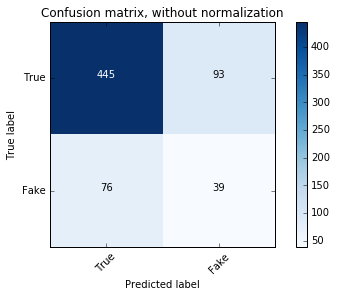

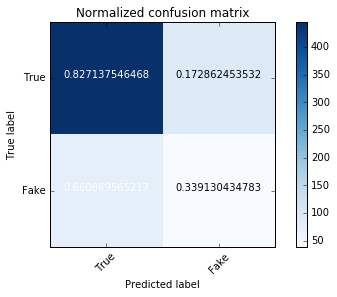

In [76]:
C = 10 #C_log[np.argmin(mean_score_l1)]
clf = LogisticRegression(C=C, penalty='l1', tol=0.01, random_state=42, class_weight='balanced')
clf.fit(X_train,y_train)

# Compute confusion matrix
y_pred = clf.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
class_names = ['True','Fake']
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

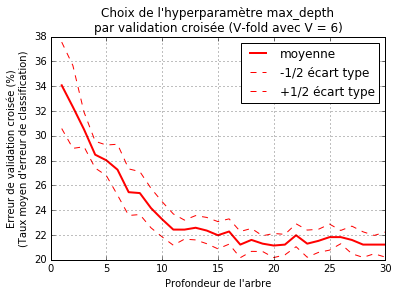

Détermination du paramètre optimal en 2.8 seconds 
Profondeur optimale de l'arbre: max_depth = 20 


In [82]:
from sklearn.tree import DecisionTreeClassifier

# Plage étudiée de k=1 à k=n_neighbors_max
max_depth_max = 30
# V-fold, nombre de fold
cv = 6
mean_scores = np.empty(max_depth_max)
std_scores = np.empty(max_depth_max)
np.random.seed(seed=42) 
startTime = time.time()
for max_depth in range(1,max_depth_max+1):
    clf = DecisionTreeClassifier(max_depth=max_depth,class_weight='balanced')
    mean_scores[max_depth-1] = 100*np.mean(1-cross_val_score(clf, X_train, y_train.loc[:,'label'], cv=cv, 
                                                             scoring='accuracy'))
    std_scores[max_depth-1] = 100*np.std(1-cross_val_score(clf, X_train, y_train.loc[:,'label'], cv=cv, 
                                                           scoring='accuracy'))
plt.figure()
x=range(1,max_depth_max+1)
plt.plot(x,mean_scores[:],'r',linewidth=2,label='moyenne')
plt.plot(x,mean_scores[:]-0.5*std_scores[:], 'r--', label=u'-1/2 écart type')
plt.plot(x,mean_scores[:]+0.5*std_scores[:],'r--', label=u'+1/2 écart type')
plt.xlabel(u"Profondeur de l'arbre")
plt.ylabel(u"Erreur de validation croisée (%)\n(Taux moyen d'erreur de classification)")
plt.title(u"Choix de l'hyperparamètre max_depth\npar validation croisée \
(V-fold avec V = %s)" % (cv)) 
plt.legend(bbox_to_anchor=(1, 1))
plt.grid()
plt.show()

print("Détermination du paramètre optimal en %0.1f seconds " % (time.time() - startTime))
print("Profondeur optimale de l'arbre: max_depth = %i " % (np.argmin(mean_scores)+1))

Confusion matrix, without normalization
[[465  73]
 [ 76  39]]
Normalized confusion matrix
[[ 0.86  0.14]
 [ 0.66  0.34]]


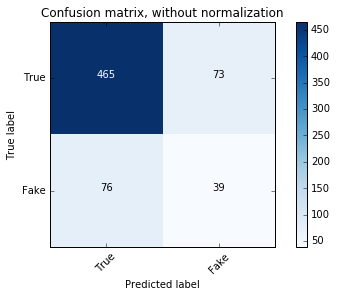

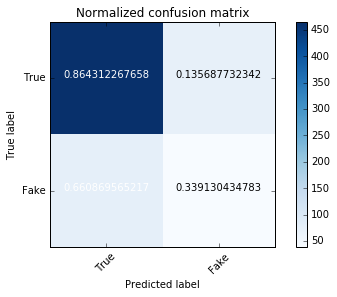

In [83]:
clf =  DecisionTreeClassifier(max_depth=20,class_weight='balanced')
clf.fit(X_train,y_train)

# Compute confusion matrix
y_pred = clf.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
class_names = ['True','Fake']
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [88]:
from sklearn.svm import SVC
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.grid_search import GridSearchCV

startTime = time.time()
C_range = np.logspace(0, 12, num=13, base=2)
gamma_range = np.logspace(-8, 4, num=13, base=2)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(y_train, n_iter=5, test_size=0.2, random_state=42)
grid = GridSearchCV(SVC(class_weight='balanced'), param_grid=param_grid, cv=cv)
grid.fit(X_train, y_train.loc[:,'label'])
print("Détermination des hyperparamètres optimaux en %0.1f s" % (time.time() - startTime))
print("Les valeurs optimales sont  %s \nScore de validation croisée : %0.2f %%" \
      % (grid.best_params_, 100*grid.best_score_))

Détermination des hyperparamètres optimaux en 95.3 s
Les valeurs optimales sont  {'C': 8.0, 'gamma': 8.0} 
Score de validation croisée : 81.21 %


//anaconda/lib/python2.7/site-packages/sklearn/svm/base.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y_ = column_or_1d(y, warn=True)
//anaconda/lib/python2.7/site-packages/sklearn/svm/base.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y_ = column_or_1d(y, warn=True)


Score de généralisation : 79.02 %
Confusion matrix, without normalization
[[473  65]
 [ 72  43]]
Normalized confusion matrix
[[ 0.88  0.12]
 [ 0.63  0.37]]


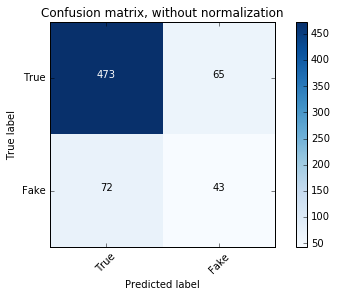

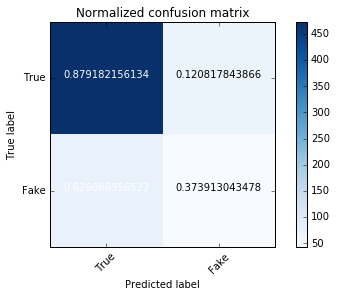

In [89]:
# Re apprentissage sur l'ensemble de jeux de validation avec C optimal
clf = SVC(C=grid.best_params_['C'], gamma=grid.best_params_['gamma'],
          kernel='rbf', random_state=42,class_weight='balanced').fit(X_train, y_train)
clf.fit(X_train,y_train)
accuracy = clf.score(X_test,y_test)
print("Score de généralisation : %0.2f %%" % (100*accuracy))

# Compute confusion matrix
y_pred = clf.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
class_names = ['True','Fake']
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [93]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.grid_search import GridSearchCV

startTime = time.time()
max_depth_range = [1,2,5,10,15,20,25,30]
n_estimators_range = [1,5,10,20,50,100]
param_grid = dict(max_depth=max_depth_range, n_estimators=n_estimators_range)
cv = StratifiedShuffleSplit(y_train, n_iter=5, test_size=0.2, random_state=42)
grid = GridSearchCV(RandomForestClassifier(class_weight='balanced'), param_grid=param_grid, cv=cv)
grid.fit(X_train, y_train.loc[:,'label'])
print("Détermination des hyperparamètres optimaux en %0.1f s" % (time.time() - startTime))
print("Les valeurs optimales sont  %s \nScore de validation croisée : %0.2f %%" \
      % (grid.best_params_, 100*grid.best_score_))

Détermination des hyperparamètres optimaux en 31.5 s
Les valeurs optimales sont  {'n_estimators': 10, 'max_depth': 25} 
Score de validation croisée : 84.08 %


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Score de généralisation : 82.24 %
Confusion matrix, without normalization
[[513  25]
 [ 91  24]]
Normalized confusion matrix
[[ 0.95  0.05]
 [ 0.79  0.21]]


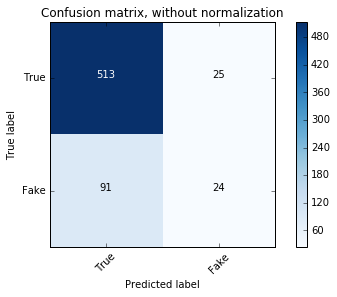

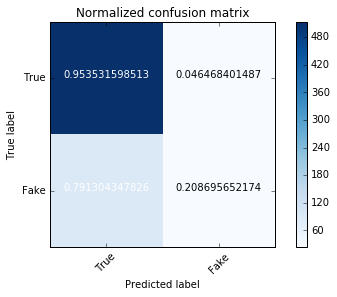

In [95]:
# Re apprentissage sur l'ensemble de jeux de validation avec C optimal
clf = RandomForestClassifier(max_depth=grid.best_params_['max_depth'], 
                             n_estimators=grid.best_params_['n_estimators'],
                             random_state=42,class_weight='balanced').fit(X_train, y_train)
clf.fit(X_train,y_train)
accuracy = clf.score(X_test,y_test)
print("Score de généralisation : %0.2f %%" % (100*accuracy))

# Compute confusion matrix
y_pred = clf.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
class_names = ['True','Fake']
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()